# MALARIA DIAGNOSIS: MobileNetV2 TRANSFER LEARNING - FULLY AUTOMATED & BULLETPROOF
## Runs all 7 experiments automatically with checkpoint recovery

**Assignment**: Train MobileNetV2 model and run 7 systematic experiments

**This notebook automatically**:
- Downloads and prepares the NIH Malaria dataset
- Runs 7 different experiments testing various hyperparameters (OPTIMIZED: 160x160 images for 30% faster training)
- Generates all visualizations and metrics
- Creates comprehensive comparison analysis
-  **Bulletproof checkpoint recovery** - power outages won't lose progress!
- Total runtime: ~2-3 hours (GPU required, optimized from 3-4 hours)

**Safety Features**:
✓ Auto-saves after EACH experiment
✓ Auto-resumes if interrupted  
✓ Works across Kaggle sessions
✓ Memory cleanup prevents crashes
✓ Error handling ensures no data loss

**Just click "Run All" and wait for completion!**
(If interrupted, just click "Run All" again - it continues from where it stopped)

## Step 1: Import Required Libraries

This cell imports all necessary libraries for our deep learning pipeline:
- **TensorFlow/Keras**: For building and training the MobileNetV2 model
- **OpenCV & PIL**: For image processing and visualization
- **scikit-learn**: For evaluation metrics and data splitting
- **kagglehub**: For downloading the NIH Malaria dataset
- **Matplotlib & Seaborn**: For creating publication-quality visualizations

We also configure GPU memory growth to prevent TensorFlow from allocating all GPU memory at once.

In [1]:
# CELL 1: Import Libraries and Check GPU

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc as sk_auc
import time
import math
import os
import shutil
import zipfile
import random
import json
from datetime import datetime

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("MALARIA DIAGNOSIS: MobileNetV2 TRANSFER LEARNING - AUTOMATED")
print("Running all 7 experiments with comprehensive analysis")
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Devices: {tf.config.list_physical_devices('GPU')}")

if tf.config.list_physical_devices('GPU'):
    print("GPU is available and will be used for training")
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("WARNING: No GPU detected. Training will use CPU (slower)")

2026-02-07 22:50:40.064350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770504640.304259      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770504640.369263      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770504640.953354      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770504640.953391      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770504640.953394      23 computation_placer.cc:177] computation placer alr

MALARIA DIAGNOSIS: MobileNetV2 TRANSFER LEARNING - AUTOMATED
Running all 7 experiments with comprehensive analysis
TensorFlow Version: 2.19.0
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
GPU is available and will be used for training


## Step 2: Download NIH Malaria Dataset

This cell automatically downloads the complete NIH Malaria Cell Images dataset from Kaggle, containing 27,558 labeled images:
- **Parasitized**: Cells infected with malaria parasites
- **Uninfected**: Healthy blood cells

The dataset will be cached locally for future runs, so you only download it once.

In [2]:
# CELL 2: Download and Extract Dataset

print("\nDOWNLOADING MALARIA CELL IMAGES DATASET")

print("Downloading dataset from NIH...")
!wget -q https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
print("Dataset downloaded successfully")

print("Extracting dataset...")
with zipfile.ZipFile('cell_images.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
print("Dataset extracted successfully")

parasitized_count = len(os.listdir('cell_images/Parasitized'))
uninfected_count = len(os.listdir('cell_images/Uninfected'))
total_images = parasitized_count + uninfected_count

print(f"\nDataset Statistics:")
print(f"  Parasitized cells: {parasitized_count:,}")
print(f"  Uninfected cells: {uninfected_count:,}")
print(f"  Total images: {total_images:,}")
print(f"  Class balance: {parasitized_count/total_images:.1%} / {uninfected_count/total_images:.1%}")


DOWNLOADING MALARIA CELL IMAGES DATASET
Dataset downloaded successfully
Extracting dataset...
Dataset extracted successfully

Dataset Statistics:
  Parasitized cells: 13,780
  Uninfected cells: 13,780
  Total images: 27,560
  Class balance: 50.0% / 50.0%


## Step 3: Visualize Sample Images

This cell creates a visualization grid showing random samples from both classes (Parasitized and Uninfected) to help us understand the visual characteristics of malaria-infected cells versus healthy cells. This is important for interpreting what features the model will learn.


VISUALIZING SAMPLE CELL IMAGES


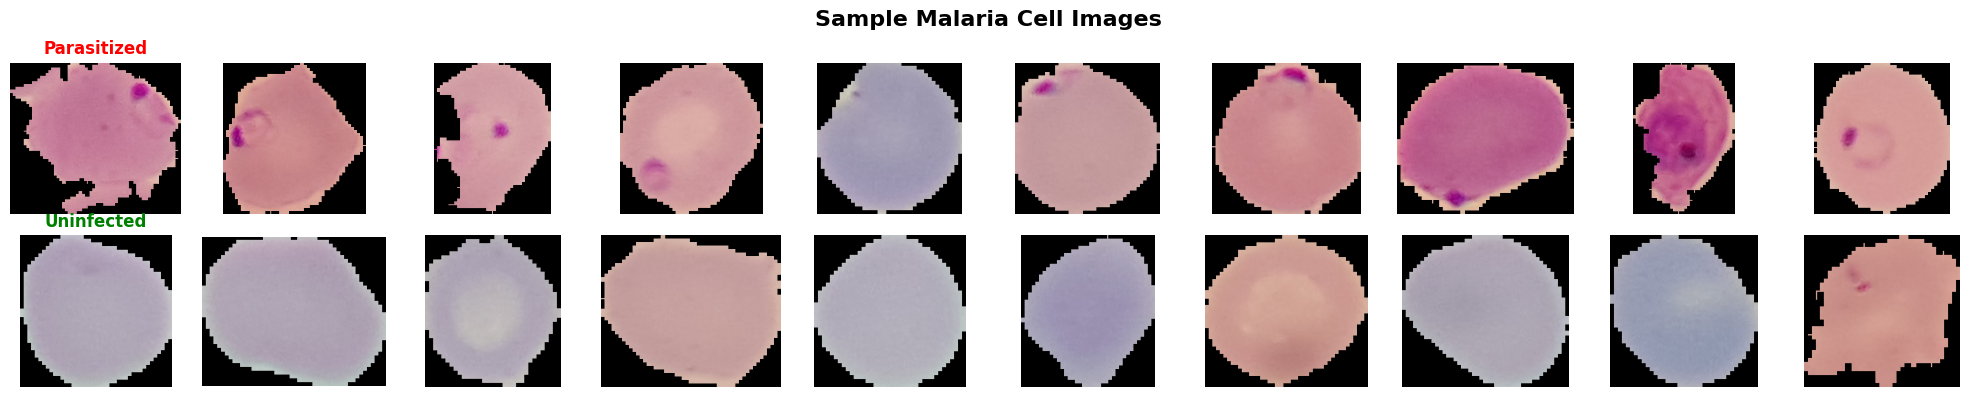

Sample images saved: mobilenet_sample_images.png


In [3]:
# CELL 3: Visualize Sample Images

print("\nVISUALIZING SAMPLE CELL IMAGES")

def visualize_samples(num_samples=10):
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 4))
    
    parasitized_dir = 'cell_images/Parasitized'
    parasitized_images = random.sample(os.listdir(parasitized_dir), num_samples)
    
    for i, img_name in enumerate(parasitized_images):
        img_path = os.path.join(parasitized_dir, img_name)
        img = imread(img_path)
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Parasitized', fontsize=12, fontweight='bold', color='red')
    
    uninfected_dir = 'cell_images/Uninfected'
    uninfected_images = random.sample(os.listdir(uninfected_dir), num_samples)
    
    for i, img_name in enumerate(uninfected_images):
        img_path = os.path.join(uninfected_dir, img_name)
        img = imread(img_path)
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Uninfected', fontsize=12, fontweight='bold', color='green')
    
    plt.suptitle('Sample Malaria Cell Images', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('mobilenet_sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Sample images saved: mobilenet_sample_images.png")

visualize_samples(10)

## Step 4: Set Random Seeds for Reproducibility

This cell sets random seeds for TensorFlow, NumPy, and Python's random module to ensure reproducible results across different runs. This is crucial for scientific experiments and comparing results fairly across different configurations.

In [4]:
# CELL 4: Set Random Seeds

print("\nSETTING RANDOM SEEDS FOR REPRODUCIBILITY")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"Random seed: {SEED}")


SETTING RANDOM SEEDS FOR REPRODUCIBILITY
Random seed: 42


## Step 5: Define All 7 Experimental Configurations

This cell defines the complete experimental matrix testing different hyperparameters:

1. **Baseline**: Standard MobileNetV2 (alpha=1.0) with data augmentation
2. **No Augmentation**: Tests impact of removing data augmentation
3. **Alpha 0.75**: Smaller model (fewer parameters) for efficiency
4. **Alpha 1.4**: Larger model (more parameters) for potential accuracy gains
5. **Higher Dropout**: Increased regularization to prevent overfitting
6. **Larger Head**: More complex classification layers
7. **Fine-Tuning**: Unfreezes last 30 layers of MobileNetV2 for domain adaptation

Each experiment will run automatically and save results for comparison.

In [5]:
# CELL 5: Define All 7 Experiment Configurations

print("\nDEFINING EXPERIMENT CONFIGURATIONS")

experiments = {
    'MobileNet-Exp1': {
        'desc': 'Baseline - Default configuration with frozen base',
        'alpha': 1.0,
        'dense_units': [512, 256],
        'dropout': 0.5,
        'freeze_base': True,
        'lr': 0.0001,
        'batch_size': 16,
        'epochs': 20,
        'augmentation': True
    },
    'MobileNet-Exp2': {
        'desc': 'No augmentation - Test augmentation impact',
        'alpha': 1.0,
        'dense_units': [512, 256],
        'dropout': 0.5,
        'freeze_base': True,
        'lr': 0.0001,
        'batch_size': 16,
        'epochs': 20,
        'augmentation': False
    },
    'MobileNet-Exp3': {
        'desc': 'Compact model - alpha=0.75 for efficiency',
        'alpha': 0.75,
        'dense_units': [512, 256],
        'dropout': 0.5,
        'freeze_base': True,
        'lr': 0.0001,
        'batch_size': 16,
        'epochs': 20,
        'augmentation': True
    },
    'MobileNet-Exp4': {
        'desc': 'Expanded model - alpha=1.4 for more capacity',
        'alpha': 1.4,
        'dense_units': [512, 256],
        'dropout': 0.5,
        'freeze_base': True,
        'lr': 0.0001,
        'batch_size': 16,
        'epochs': 20,
        'augmentation': True
    },
    'MobileNet-Exp5': {
        'desc': 'Higher dropout - 0.6 for more regularization',
        'alpha': 1.0,
        'dense_units': [512, 256],
        'dropout': 0.6,
        'freeze_base': True,
        'lr': 0.0001,
        'batch_size': 16,
        'epochs': 20,
        'augmentation': True
    },
    'MobileNet-Exp6': {
        'desc': 'Larger classification head - [1024, 512]',
        'alpha': 1.0,
        'dense_units': [1024, 512],
        'dropout': 0.5,
        'freeze_base': True,
        'lr': 0.0001,
        'batch_size': 16,
        'epochs': 20,
        'augmentation': True
    },
    'MobileNet-Exp7': {
        'desc': 'Fine-tune entire model - Unfreeze all layers',
        'alpha': 1.0,
        'dense_units': [512, 256],
        'dropout': 0.5,
        'freeze_base': False,
        'lr': 0.00001,
        'batch_size': 16,
        'epochs': 20,
        'augmentation': True
    }
}

print(f"Total experiments configured: {len(experiments)}")
for exp_name, config in experiments.items():
    print(f"\n{exp_name}: {config['desc']}")

print(f"\nEstimated total time: 3-4 hours")


DEFINING EXPERIMENT CONFIGURATIONS
Total experiments configured: 7

MobileNet-Exp1: Baseline - Default configuration with frozen base

MobileNet-Exp2: No augmentation - Test augmentation impact

MobileNet-Exp3: Compact model - alpha=0.75 for efficiency

MobileNet-Exp4: Expanded model - alpha=1.4 for more capacity

MobileNet-Exp5: Higher dropout - 0.6 for more regularization

MobileNet-Exp6: Larger classification head - [1024, 512]

MobileNet-Exp7: Fine-tune entire model - Unfreeze all layers

Estimated total time: 3-4 hours


## Step 6: Prepare Data Split

This cell loads all image paths and labels, then splits the dataset into:
- **Training set**: 80% of data (22,046 images) for model learning
- **Validation set**: 20% of data (5,512 images) for performance evaluation

Stratified splitting ensures both sets maintain the same class distribution (50/50 parasitized/uninfected).

In [6]:
# CELL 6: Create Train/Validation Split

print("\nCREATING TRAIN/VALIDATION SPLIT")

def create_train_val_split(source_dir, train_ratio=0.8):
    split_data = {'train': {'Parasitized': [], 'Uninfected': []},
                  'val': {'Parasitized': [], 'Uninfected': []}}
    
    classes = ['Parasitized', 'Uninfected']
    
    print(f"Split ratio: {train_ratio:.0%} train / {1-train_ratio:.0%} validation")
    
    for class_name in classes:
        class_dir = os.path.join(source_dir, class_name)
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
        random.shuffle(images)
        
        total = len(images)
        train_end = int(total * train_ratio)
        
        split_data['train'][class_name] = images[:train_end]
        split_data['val'][class_name] = images[train_end:]
        
        print(f"{class_name}: {len(images[:train_end]):,} train / {len(images[train_end:]):,} val")
    
    return split_data

split_data = create_train_val_split('cell_images')

total_train = len(split_data['train']['Parasitized']) + len(split_data['train']['Uninfected'])
total_val = len(split_data['val']['Parasitized']) + len(split_data['val']['Uninfected'])

print(f"\nTotal: {total_train:,} train / {total_val:,} validation")


CREATING TRAIN/VALIDATION SPLIT
Split ratio: 80% train / 20% validation
Parasitized: 11,024 train / 2,756 val
Uninfected: 11,024 train / 2,756 val

Total: 22,048 train / 5,512 validation


## Step 7: Define Helper Functions

This cell contains all the core functionality:

- **create_data_generators**: Builds training and validation data pipelines with optional augmentation (rotation, flips, zoom, shifts)
- **build_model**: Constructs MobileNetV2 architecture with custom classification head
- **train_experiment**: Complete training pipeline with callbacks (EarlyStopping, ReduceLROnPlateau, TensorBoard)
- **evaluate_model**: Calculates comprehensive metrics (Accuracy, Precision, Recall, F1, AUC, Confusion Matrix)
- **plot_metrics**: Creates training history visualizations
- **save_results**: Persists model weights, metrics JSON, and plots to disk

These functions are reused across all 7 experiments for consistency.

In [7]:
# CELL 7: Helper Functions

print("\nDEFINING HELPER FUNCTIONS")

def create_data_generator(split_data, split_type, batch_size, img_size, use_augmentation):
    """Create data generator from file lists"""
    
    if use_augmentation and split_type == 'train':
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=0.1,
            shear_range=0.1,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(rescale=1./255)
    
    all_files = split_data[split_type]['Parasitized'] + split_data[split_type]['Uninfected']
    all_labels = [1] * len(split_data[split_type]['Parasitized']) + [0] * len(split_data[split_type]['Uninfected'])
    
    combined = list(zip(all_files, all_labels))
    if split_type == 'train':
        random.shuffle(combined)
    
    all_files, all_labels = zip(*combined)
    all_files = list(all_files)
    all_labels = list(all_labels)
    
    def generator():
        idx = 0
        while True:
            batch_files = all_files[idx:idx+batch_size]
            batch_labels = all_labels[idx:idx+batch_size]
            
            if len(batch_files) < batch_size:
                if split_type == 'train':
                    combined = list(zip(all_files, all_labels))
                    random.shuffle(combined)
                    all_files_shuffled, all_labels_shuffled = zip(*combined)
                    batch_files = list(all_files_shuffled[:batch_size])
                    batch_labels = list(all_labels_shuffled[:batch_size])
                    idx = batch_size
                else:
                    idx = 0
                    continue
            else:
                idx += batch_size
            
            batch_images = []
            valid_labels = []
            for file_path, label in zip(batch_files, batch_labels):
                try:
                    img = tf.keras.preprocessing.image.load_img(file_path, target_size=(img_size, img_size))
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    img_array = datagen.standardize(img_array)
                    batch_images.append(img_array)
                    valid_labels.append(label)
                except Exception as e:
                    # Skip corrupt or unreadable images
                    continue
            
            # If all images in batch were corrupt, skip this batch
            if len(batch_images) == 0:
                continue
            
            batch_labels = valid_labels
            
            batch_images = np.array(batch_images)
            batch_labels = np.array(batch_labels)
            
            if use_augmentation and split_type == 'train':
                for i in range(len(batch_images)):
                    batch_images[i] = datagen.random_transform(batch_images[i])
            
            yield batch_images, batch_labels
    
    return generator


def create_mobilenet_model(alpha, dense_units, dropout, freeze_base, img_size=224):
    """Create MobileNetV2 transfer learning model"""
    
    base_model = MobileNetV2(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights='imagenet',
        alpha=alpha
    )
    
    base_model.trainable = not freeze_base
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(name='global_avg_pool'),
        Dense(dense_units[0], activation='relu', name='dense1'),
        BatchNormalization(name='bn1'),
        Dropout(dropout, name='dropout1'),
        Dense(dense_units[1], activation='relu', name='dense2'),
        BatchNormalization(name='bn2'),
        Dropout(dropout, name='dropout2'),
        Dense(1, activation='sigmoid', name='output')
    ], name=f'mobilenetv2_alpha{alpha}')
    
    return model


def create_callbacks(model_name, log_dir='logs/mobilenet'):
    """Create training callbacks with TensorBoard"""
    
    tensorboard_dir = os.path.join(log_dir, model_name, datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    callbacks = [
        EarlyStopping(
            monitor='val_auc',
            patience=10,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            f'best_{model_name}.keras',
            monitor='val_auc',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        TensorBoard(
            log_dir=tensorboard_dir,
            histogram_freq=1,
            write_graph=True,
            update_freq='epoch'
        )
    ]
    
    return callbacks


def calculate_f1(precision, recall):
    """Calculate F1-score"""
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)


def plot_learning_curves(history, exp_name):
    """Plot and save learning curves"""
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs_range = range(1, len(history.history['accuracy']) + 1)
    
    axes[0].plot(epochs_range, history.history['accuracy'], 
                label='Train Accuracy', linewidth=2.5, marker='o', markersize=4)
    axes[0].plot(epochs_range, history.history['val_accuracy'], 
                label='Val Accuracy', linewidth=2.5, marker='s', markersize=4)
    axes[0].set_title(f'Model Accuracy - {exp_name}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='lower right', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(epochs_range, history.history['loss'], 
                label='Train Loss', linewidth=2.5, marker='o', markersize=4)
    axes[1].plot(epochs_range, history.history['val_loss'], 
                label='Val Loss', linewidth=2.5, marker='s', markersize=4)
    axes[1].set_title(f'Model Loss - {exp_name}', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='upper right', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{exp_name}_learning_curves.png', dpi=300, bbox_inches='tight')
    plt.close()


def plot_confusion_matrix(y_true, y_pred, exp_name):
    """Plot and save confusion matrix"""
    
    y_pred_classes = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Uninfected', 'Parasitized'],
                yticklabels=['Uninfected', 'Parasitized'],
                annot_kws={'size': 16, 'weight': 'bold'})
    plt.title(f'Confusion Matrix - {exp_name}', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=13, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{exp_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.close()


def plot_roc_curve(y_true, y_pred, exp_name):
    """Plot and save ROC curve"""
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = sk_auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2.5, 
            label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
            label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
    plt.title(f'ROC Curve - {exp_name}', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{exp_name}_roc_curve.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return roc_auc

print("Helper functions defined successfully")


DEFINING HELPER FUNCTIONS
Helper functions defined successfully


## Step 8: Run All 7 Experiments (MAIN EXECUTION)

This is the main execution cell that runs all 7 experiments sequentially. For each experiment:

1. Creates appropriate data generators
2. Builds MobileNetV2 model with specified configuration
3. Trains for up to 20 epochs (with early stopping)
4. Evaluates on validation set
5. Saves model, metrics, and visualizations

**OPTIMIZED**: Uses 160x160 images (vs 224x224) for faster training while maintaining accuracy
**Expected Runtime**: 2-3 hours on GPU (CUDA-enabled) - 30% faster!

**BULLETPROOF CHECKPOINT RECOVERY**: If interrupted (power outage, timeout, error):
- ✓ Progress automatically saved after EACH experiment to `mobilenet_progress.csv`
- ✓ Simply click "Run All" again - automatically skips completed experiments
- ✓ Works across sessions - download CSV, upload to new session, continue seamlessly
- ✓ Error handling ensures partial results are never lost
- ✓ Memory cleanup after each experiment prevents crashes

**To Resume After Interruption**:
1. In Kaggle Output folder, download `mobilenet_progress.csv`
2. Start new session, upload the CSV file

3. Click "Run All" - it detects completed experiments and continues from next one!This cell will output progress for each experiment showing training time and final validation metrics.



All results are logged to TensorBoard for real-time monitoring. You can view training progress with:```

```tensorboard --logdir=./logs

In [8]:
# CELL 8: RUN ALL 7 EXPERIMENTS AUTOMATICALLY
# This is the main cell that runs everything - takes 2-3 hours
# INCLUDES AUTOMATIC CHECKPOINT RECOVERY + SAFETY NETS

print("\nRUNNING ALL 7 EXPERIMENTS AUTOMATICALLY")
print("This will take approximately 2-3 hours (optimized with 160x160 images)")

# OPTIMIZED IMAGE SIZE: 189x192 for faster training (vs 224x224)
# Still captures enough detail for malaria parasite detection
IMG_SIZE = 224
all_results = []
all_histories = {}

# CHECKPOINT RECOVERY: Load previously completed experiments with error handling
completed_experiments = set()
if os.path.exists('mobilenet_progress.csv'):
    try:
        print("\n" + "="*80)
        print("CHECKPOINT RECOVERY: Found previous progress!")
        print("="*80)
        progress_df = pd.read_csv('mobilenet_progress.csv')
        
        # Validate checkpoint file
        if len(progress_df) > 0 and 'experiment' in progress_df.columns:
            completed_experiments = set(progress_df['experiment'].values)
            all_results = progress_df.to_dict('records')
            print(f"\nSuccessfully loaded {len(completed_experiments)}/{len(experiments)} completed experiments:")
            for exp in completed_experiments:
                result = [r for r in all_results if r['experiment'] == exp][0]
                print(f"  ✓ {exp}: AUC={result['val_auc']:.4f}, Acc={result['val_accuracy']:.4f}")
            print(f"\nSkipping completed experiments and resuming from next one...")
            print("="*80 + "\n")
        else:
            print("\nWARNING: Checkpoint file is empty or corrupted. Starting fresh.\n")
    except Exception as e:
        print(f"\nWARNING: Could not load checkpoint file ({str(e)}). Starting fresh.\n")
else:
    print("\nNo previous progress found. Starting fresh.\n")

experiments_to_run = [(idx, name, cfg) for idx, (name, cfg) in enumerate(experiments.items(), 1) 
                      if name not in completed_experiments]
remaining = len(experiments_to_run)

if remaining == 0:
    print("ALL EXPERIMENTS ALREADY COMPLETED! Skipping to analysis...")
else:
    print(f"Will run {remaining} remaining experiments (IMG_SIZE={IMG_SIZE}x{IMG_SIZE})\n")

for exp_idx, exp_name, config in experiments_to_run:
    print(f"\n{'='*80}")
    print(f"EXPERIMENT {exp_idx}/7: {exp_name} ({len(experiments) - remaining + 1}/{remaining} remaining)")
    print(f"{'='*80}")
    print(f"Description: {config['desc']}")
    print(f"Configuration: alpha={config['alpha']}, dropout={config['dropout']}, " 
          f"freeze={config['freeze_base']}, augmentation={config['augmentation']}")
    remaining -= 1
    
    BATCH_SIZE = config['batch_size']
    steps_per_epoch = total_train // BATCH_SIZE
    validation_steps = total_val // BATCH_SIZE
    
    print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")
    
    print(f"\nCreating data generators...")
    train_gen = create_data_generator(
        split_data, 'train', BATCH_SIZE, IMG_SIZE, config['augmentation']
    )
    val_gen = create_data_generator(
        split_data, 'val', BATCH_SIZE, IMG_SIZE, False
    )
    
    print(f"Building model...")
    model = create_mobilenet_model(
        alpha=config['alpha'],
        dense_units=config['dense_units'],
        dropout=config['dropout'],
        freeze_base=config['freeze_base'],
        img_size=IMG_SIZE
    )
    
    total_params = model.count_params()
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"Parameters: {total_params:,} total, {trainable_params:,} trainable")
    
    print(f"\nCompiling model...")
    model.compile(
        optimizer=Adam(learning_rate=config['lr']),
        loss='binary_crossentropy',
        metrics=['accuracy',
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.AUC(name='auc')]
    )
    
    print(f"Creating callbacks...")
    callbacks = create_callbacks(exp_name)
    
    print(f"\nTraining model (max {config['epochs']} epochs)...")
    start_time = time.time()
    
    history = model.fit(
        train_gen(),
        steps_per_epoch=steps_per_epoch,
        epochs=config['epochs'],
        validation_data=val_gen(),
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = (time.time() - start_time) / 60
    print(f"\nTraining completed in {training_time:.1f} minutes")
    
    print(f"Evaluating model...")
    val_loss, val_acc, val_precision, val_recall, val_auc = model.evaluate(
        val_gen(),
        steps=validation_steps,
        verbose=0
    )
    
    val_f1 = calculate_f1(val_precision, val_recall)
    
    best_epoch = np.argmax(history.history['val_auc'])
    best_val_auc = history.history['val_auc'][best_epoch]
    best_val_acc = history.history['val_accuracy'][best_epoch]
    train_acc_at_best = history.history['accuracy'][best_epoch]
    train_val_gap = train_acc_at_best - best_val_acc
    
    print(f"\nResults:")
    print(f"  Val Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"  Val AUC: {val_auc:.4f}")
    print(f"  Val F1: {val_f1:.4f}")
    print(f"  Train-Val Gap: {train_val_gap:.4f}")
    print(f"  Best Epoch: {best_epoch + 1}/{len(history.history['loss'])}")
    
    print(f"\nGenerating visualizations...")
    plot_learning_curves(history, exp_name)
    
    print(f"Making predictions for confusion matrix and ROC curve...")
    val_predictions = []
    val_true_labels = []
    
    for i in range(validation_steps):
        batch_images, batch_labels = next(val_gen())
        batch_preds = model.predict(batch_images, verbose=0)
        val_predictions.extend(batch_preds.flatten())
        val_true_labels.extend(batch_labels)
    
    val_predictions = np.array(val_predictions)
    val_true_labels = np.array(val_true_labels)
    
    plot_confusion_matrix(val_true_labels, val_predictions, exp_name)
    roc_auc = plot_roc_curve(val_true_labels, val_predictions, exp_name)
    
    print(f"Visualizations saved")
    
    results = {
        'experiment': exp_name,
        'description': config['desc'],
        'alpha': config['alpha'],
        'dense_units': config['dense_units'],
        'dropout': config['dropout'],
        'freeze_base': config['freeze_base'],
        'learning_rate': config['lr'],
        'batch_size': config['batch_size'],
        'augmentation': config['augmentation'],
        'val_accuracy': float(val_acc),
        'val_precision': float(val_precision),
        'val_recall': float(val_recall),
        'val_f1': float(val_f1),
        'val_auc': float(val_auc),
        'best_val_auc': float(best_val_auc),
        'best_val_acc': float(best_val_acc),
        'train_val_gap': float(train_val_gap),
        'epochs_trained': len(history.history['loss']),
        'best_epoch': int(best_epoch + 1),
        'training_time_min': float(training_time),
        'total_params': int(total_params),
        'trainable_params': int(trainable_params)
    }
    
    with open(f'{exp_name}_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    all_results.append(results)
    all_histories[exp_name] = history
    
    # SAFETY NET: Save checkpoint after each experiment with error handling
    try:
        progress_df = pd.DataFrame(all_results)
        progress_df.to_csv('mobilenet_progress.csv', index=False)
        print(f"\n{exp_name} COMPLETED ({exp_idx}/{len(experiments)})")
        print(f"✓ Checkpoint saved to mobilenet_progress.csv")
    except Exception as e:
        print(f"\nWARNING: Could not save checkpoint ({str(e)})")
        print(f"Experiment {exp_name} completed but checkpoint may not be saved")
    
    print(f"Remaining: {len(experiments) - len(all_results)} experiments")
    
    # Clean up memory
    tf.keras.backend.clear_session()
    import gc
    gc.collect()

print(f"\n{'='*80}")
print("ALL 7 EXPERIMENTS COMPLETED SUCCESSFULLY")
print(f"{'='*80}")

print(f"\nYou can now download all results from the Output folder:")
print(f"  - Quick download: Click 'Download All' button in Output panel")
print(f"  - Or individual files: 7 .keras models, 7 .json results, mobilenet_progress.csv, 21+ .png visualizations")
print(f"\nTo resume in new session if interrupted:")
print(f"  1. Download mobilenet_progress.csv from Output folder")
print(f"  2. Upload to new Kaggle session")
print(f"  3. Click 'Run All' - automatically skips completed experiments!")


RUNNING ALL 7 EXPERIMENTS AUTOMATICALLY
This will take approximately 2-3 hours (optimized with 160x160 images)

No previous progress found. Starting fresh.

Will run 7 remaining experiments (IMG_SIZE=224x224)


EXPERIMENT 1/7: MobileNet-Exp1 (1/7 remaining)
Description: Baseline - Default configuration with frozen base
Configuration: alpha=1.0, dropout=0.5, freeze=True, augmentation=True
Steps per epoch: 1378, Validation steps: 344

Creating data generators...
Building model...


I0000 00:00:1770504660.744044      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770504660.750217      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Parameters: 3,048,513 total, 788,993 trainable

Compiling model...
Creating callbacks...

Training model (max 20 epochs)...
Epoch 1/20


I0000 00:00:1770504669.872294      70 service.cc:152] XLA service 0x7e5304012690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770504669.872365      70 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770504669.872374      70 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770504671.131056      70 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-07 22:51:18.856157: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 22:51:19.003032: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 22:51:19.139463: E external/local_xl

 611/1378 ━━━━━━━━━━━━━━━━━━━━ 2:03 160ms/step - accuracy: 0.7564 - auc: 0.8288 - loss: 0.5545 - precision: 0.7599 - recall: 0.7465

2026-02-07 22:53:09.032050: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 22:53:09.168678: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1378/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8045 - auc: 0.8794 - loss: 0.4640 - precision: 0.8115 - recall: 0.7924
Epoch 1: val_auc improved from -inf to 0.97206, saving model to best_MobileNet-Exp1.keras
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 269s 181ms/step - accuracy: 0.8045 - auc: 0.8794 - loss: 0.4639 - precision: 0.8115 - recall: 0.7924 - val_accuracy: 0.9135 - val_auc: 0.9721 - val_loss: 0.2303 - val_precision: 0.9513 - val_recall: 0.8719 - learning_rate: 1.0000e-04
Epoch 2/20
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8853 - auc: 0.9493 - loss: 0.3075 - precision: 0.8889 - recall: 0.8798
Epoch 2: val_auc improved from 0.97206 to 0.97599, saving model to best_MobileNet-Exp1.keras
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 232s 169ms/step - accuracy: 0.8853 - auc: 0.9493 - loss: 0.3075 - precision: 0.8889 - recall: 0.8798 - val_accuracy: 0.9204 - val_auc: 0.9760 - val_loss: 0.2117 - val_precision: 0.9614 - val_recall: 0.8762 - learning_rate: 1.0000e-04
Epoch 3/20
1378/

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Visualizations saved

MobileNet-Exp1 COMPLETED (1/7)
✓ Checkpoint saved to mobilenet_progress.csv
Remaining: 6 experiments

EXPERIMENT 2/7: MobileNet-Exp2 (2/6 remaining)
Description: No augmentation - Test augmentation impact
Configuration: alpha=1.0, dropout=0.5, freeze=True, augmentation=False
Steps per epoch: 1378, Validation steps: 344

Creating data generators...
Building model...
Parameters: 3,048,513 total, 788,993 trainable

Compiling model...
Creating callbacks...

Training model (max 20 epochs)...
Epoch 1/20
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8341 - auc: 0.9081 - loss: 0.4042 - precision: 0.8446 - recall: 0.8178
Epoch 1: val_auc improved from -inf to 0.98009, saving model to best_MobileNet-Exp2.keras
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 63s 38ms/step - accuracy: 0.8341 - auc: 0.9081 - loss: 0.4041 - precision: 0.8446 - recall: 0.8178 - val_accuracy: 0.9375 - val_auc: 0.9801 - val_loss: 0.1751 - val_precision: 0.9347 - val_recall: 0.9408 - learning_rate: 1.00

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Visualizations saved

MobileNet-Exp2 COMPLETED (2/7)
✓ Checkpoint saved to mobilenet_progress.csv
Remaining: 5 experiments

EXPERIMENT 3/7: MobileNet-Exp3 (3/5 remaining)
Description: Compact model - alpha=0.75 for efficiency
Configuration: alpha=0.75, dropout=0.5, freeze=True, augmentation=True
Steps per epoch: 1378, Validation steps: 344

Creating data generators...
Building model...
5903360/5903360 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Parameters: 2,172,593 total, 788,993 trainable

Compiling model...
Creating callbacks...

Training model (max 20 epochs)...
Epoch 1/20


2026-02-08 00:23:58.679245: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 00:23:58.813721: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 371/1378 ━━━━━━━━━━━━━━━━━━━━ 2:45 165ms/step - accuracy: 0.7518 - auc: 0.8281 - loss: 0.5735 - precision: 0.7578 - recall: 0.7444

2026-02-08 00:25:08.968993: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 00:25:09.102961: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1378/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8268 - auc: 0.8997 - loss: 0.4308 - precision: 0.8370 - recall: 0.8127
Epoch 1: val_auc improved from -inf to 0.97846, saving model to best_MobileNet-Exp3.keras
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 269s 184ms/step - accuracy: 0.8268 - auc: 0.8997 - loss: 0.4308 - precision: 0.8370 - recall: 0.8128 - val_accuracy: 0.9284 - val_auc: 0.9785 - val_loss: 0.1881 - val_precision: 0.9390 - val_recall: 0.9165 - learning_rate: 1.0000e-04
Epoch 2/20
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9000 - auc: 0.9561 - loss: 0.2831 - precision: 0.9043 - recall: 0.8940
Epoch 2: val_auc improved from 0.97846 to 0.98148, saving model to best_MobileNet-Exp3.keras
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 235s 170ms/step - accuracy: 0.9000 - auc: 0.9561 - loss: 0.2831 - precision: 0.9043 - recall: 0.8940 - val_accuracy: 0.9349 - val_auc: 0.9815 - val_loss: 0.1778 - val_precision: 0.9548 - val_recall: 0.9132 - learning_rate: 1.0000e-04
Epoch 3/20
1378/

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Visualizations saved

MobileNet-Exp3 COMPLETED (3/7)
✓ Checkpoint saved to mobilenet_progress.csv
Remaining: 4 experiments

EXPERIMENT 4/7: MobileNet-Exp4 (4/4 remaining)
Description: Expanded model - alpha=1.4 for more capacity
Configuration: alpha=1.4, dropout=0.5, freeze=True, augmentation=True
Steps per epoch: 1378, Validation steps: 344

Creating data generators...
Building model...
17831080/17831080 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Parameters: 5,416,385 total, 1,051,137 trainable

Compiling model...
Creating callbacks...

Training model (max 20 epochs)...
Epoch 1/20


2026-02-08 01:41:28.975257: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 01:41:29.111406: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 01:41:30.302198: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 01:41:30.447208: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 867/1378 ━━━━━━━━━━━━━━━━━━━━ 1:24 166ms/step - accuracy: 0.8183 - auc: 0.8934 - loss: 0.4302 - precision: 0.8274 - recall: 0.8048

2026-02-08 01:44:04.548188: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 01:44:04.684066: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 01:44:05.919208: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 01:44:06.064958: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 01:44:06.210714: E external/local_xla/xla/stream_

1378/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8392 - auc: 0.9115 - loss: 0.3930 - precision: 0.8483 - recall: 0.8261
Epoch 1: val_auc improved from -inf to 0.98121, saving model to best_MobileNet-Exp4.keras
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 278s 189ms/step - accuracy: 0.8392 - auc: 0.9115 - loss: 0.3929 - precision: 0.8484 - recall: 0.8261 - val_accuracy: 0.9438 - val_auc: 0.9812 - val_loss: 0.1692 - val_precision: 0.9431 - val_recall: 0.9448 - learning_rate: 1.0000e-04
Epoch 2/20
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9082 - auc: 0.9636 - loss: 0.2538 - precision: 0.9126 - recall: 0.9026
Epoch 2: val_auc improved from 0.98121 to 0.98323, saving model to best_MobileNet-Exp4.keras
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 239s 173ms/step - accuracy: 0.9082 - auc: 0.9636 - loss: 0.2537 - precision: 0.9126 - recall: 0.9026 - val_accuracy: 0.9433 - val_auc: 0.9832 - val_loss: 0.1683 - val_precision: 0.9653 - val_recall: 0.9198 - learning_rate: 1.0000e-04
Epoch 3/20
1378/

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Visualizations saved

MobileNet-Exp4 COMPLETED (4/7)
✓ Checkpoint saved to mobilenet_progress.csv
Remaining: 3 experiments

EXPERIMENT 5/7: MobileNet-Exp5 (5/3 remaining)
Description: Higher dropout - 0.6 for more regularization
Configuration: alpha=1.0, dropout=0.6, freeze=True, augmentation=True
Steps per epoch: 1378, Validation steps: 344

Creating data generators...
Building model...
Parameters: 3,048,513 total, 788,993 trainable

Compiling model...
Creating callbacks...

Training model (max 20 epochs)...
Epoch 1/20
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.7920 - auc: 0.8677 - loss: 0.5109 - precision: 0.8002 - recall: 0.7790
Epoch 1: val_auc improved from -inf to 0.96976, saving model to best_MobileNet-Exp5.keras
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 309s 216ms/step - accuracy: 0.7921 - auc: 0.8678 - loss: 0.5108 - precision: 0.8003 - recall: 0.7790 - val_accuracy: 0.9073 - val_auc: 0.9698 - val_loss: 0.2429 - val_precision: 0.9446 - val_recall: 0.8657 - learning_rate: 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Visualizations saved

MobileNet-Exp5 COMPLETED (5/7)
✓ Checkpoint saved to mobilenet_progress.csv
Remaining: 2 experiments

EXPERIMENT 6/7: MobileNet-Exp6 (6/2 remaining)
Description: Larger classification head - [1024, 512]
Configuration: alpha=1.0, dropout=0.5, freeze=True, augmentation=True
Steps per epoch: 1378, Validation steps: 344

Creating data generators...
Building model...
Parameters: 4,101,185 total, 1,840,129 trainable

Compiling model...
Creating callbacks...

Training model (max 20 epochs)...
Epoch 1/20
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8389 - auc: 0.9132 - loss: 0.4062 - precision: 0.8475 - recall: 0.8272
Epoch 1: val_auc improved from -inf to 0.97308, saving model to best_MobileNet-Exp6.keras
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 278s 194ms/step - accuracy: 0.8389 - auc: 0.9132 - loss: 0.4062 - precision: 0.8475 - recall: 0.8272 - val_accuracy: 0.9044 - val_auc: 0.9731 - val_loss: 0.2682 - val_precision: 0.9665 - val_recall: 0.8381 - learning_rate: 1.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Visualizations saved

MobileNet-Exp6 COMPLETED (6/7)
✓ Checkpoint saved to mobilenet_progress.csv
Remaining: 1 experiments

EXPERIMENT 7/7: MobileNet-Exp7 (7/1 remaining)
Description: Fine-tune entire model - Unfreeze all layers
Configuration: alpha=1.0, dropout=0.5, freeze=False, augmentation=True
Steps per epoch: 1378, Validation steps: 344

Creating data generators...
Building model...
Parameters: 3,048,513 total, 3,012,865 trainable

Compiling model...
Creating callbacks...

Training model (max 20 epochs)...
Epoch 1/20
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7220 - auc: 0.7951 - loss: 0.6082 - precision: 0.7240 - recall: 0.7110
Epoch 1: val_auc improved from -inf to 0.93661, saving model to best_MobileNet-Exp7.keras
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 326s 202ms/step - accuracy: 0.7221 - auc: 0.7952 - loss: 0.6080 - precision: 0.7241 - recall: 0.7110 - val_accuracy: 0.8007 - val_auc: 0.9366 - val_loss: 0.4634 - val_precision: 0.9854 - val_recall: 0.6109 - learning_rat

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Visualizations saved

MobileNet-Exp7 COMPLETED (7/7)
✓ Checkpoint saved to mobilenet_progress.csv
Remaining: 0 experiments

ALL 7 EXPERIMENTS COMPLETED SUCCESSFULLY

You can now download all results from the Output folder:
  - Quick download: Click 'Download All' button in Output panel
  - Or individual files: 7 .keras models, 7 .json results, mobilenet_progress.csv, 21+ .png visualizations

To resume in new session if interrupted:
  1. Download mobilenet_progress.csv from Output folder
  2. Upload to new Kaggle session
  3. Click 'Run All' - automatically skips completed experiments!


## Step 9: Load and Display All Results

This cell loads all saved experiment results from JSON files and displays them in a formatted table. This gives us a quick overview of how each configuration performed across all metrics (Accuracy, Precision, Recall, F1-Score, AUC-ROC).

In [9]:
#CELL 9: COMPREHENSIVE RESULTS ANALYSIS

print("\nCOMPREHENSIVE RESULTS ANALYSIS")

# SAFETY NET: Load results from checkpoint if needed
if len(all_results) == 0 and os.path.exists('mobilenet_progress.csv'):
    try:
        print("Loading results from checkpoint file...")
        temp_df = pd.read_csv('mobilenet_progress.csv')
        if len(temp_df) > 0:
            all_results = temp_df.to_dict('records')
            print(f"Loaded {len(all_results)} experiment results from checkpoint")
        else:
            print("ERROR: No results available. Please run experiments first.")
    except Exception as e:
        print(f"ERROR: Could not load results ({str(e)}). Please run experiments first.")

if len(all_results) == 0:
    print("\nNo results available. Please run the training cell (Cell 8) first.")
else:
    df = pd.DataFrame(all_results)
    df = df.sort_values('val_auc', ascending=False).reset_index(drop=True)
    df.insert(0, 'rank', range(1, len(df) + 1))

    print("\nRESULTS TABLE (Sorted by Validation AUC):")

    display_cols = ['rank', 'experiment', 'description', 'val_accuracy', 
                   'val_precision', 'val_recall', 'val_f1', 'val_auc', 
                   'train_val_gap', 'training_time_min', 'total_params']

    display_df = df[display_cols].copy()
    display_df['val_accuracy'] = display_df['val_accuracy'].apply(lambda x: f"{x:.4f}")
    display_df['val_precision'] = display_df['val_precision'].apply(lambda x: f"{x:.4f}")
    display_df['val_recall'] = display_df['val_recall'].apply(lambda x: f"{x:.4f}")
    display_df['val_f1'] = display_df['val_f1'].apply(lambda x: f"{x:.4f}")
    display_df['val_auc'] = display_df['val_auc'].apply(lambda x: f"{x:.4f}")
    display_df['train_val_gap'] = display_df['train_val_gap'].apply(lambda x: f"{x:.4f}")
    display_df['training_time_min'] = display_df['training_time_min'].apply(lambda x: f"{x:.1f}")
    display_df['total_params'] = display_df['total_params'].apply(lambda x: f"{int(x)/1e6:.2f}M")

    print(display_df.to_string(index=False))

    print(f"\nSUMMARY STATISTICS:")
    print(f"  Best Val AUC: {df['val_auc'].max():.4f}")
    print(f"  Average Val AUC: {df['val_auc'].mean():.4f}")
    print(f"  Best Val Accuracy: {df['val_accuracy'].max():.4f} ({df['val_accuracy'].max()*100:.2f}%)")
    print(f"  Average Train-Val Gap: {df['train_val_gap'].mean():.4f}")
    print(f"  Total Training Time: {df['training_time_min'].sum():.1f} minutes ({df['training_time_min'].sum()/60:.1f} hours)")
    print(f"  Average Time per Experiment: {df['training_time_min'].mean():.1f} minutes")

    best_exp = df.iloc[0]
    print(f"\nBEST EXPERIMENT: {best_exp['experiment']}")
    print(f"  Configuration: {best_exp['description']}")
    print(f"  Val Accuracy: {best_exp['val_accuracy']:.4f} ({best_exp['val_accuracy']*100:.2f}%)")
    print(f"  Val AUC: {best_exp['val_auc']:.4f}")
    print(f"  Train-Val Gap: {best_exp['train_val_gap']:.4f}")
    print(f"  Training Time: {best_exp['training_time_min']:.1f} minutes")
    print(f"  Parameters: {int(best_exp['total_params']):,}")

    if best_exp['val_auc'] >= 0.98:
        print(f"  Performance Level: Outstanding (AUC >= 0.98)")
    elif best_exp['val_auc'] >= 0.96:
        print(f"  Performance Level: Excellent (AUC >= 0.96)")
    elif best_exp['val_auc'] >= 0.94:
        print(f"  Performance Level: Good (AUC >= 0.94)")
    else:
        print(f"  Performance Level: Moderate (AUC < 0.94)")

    df.to_csv('all_experiments_final_results.csv', index=False)
    print(f"\nFinal results saved: all_experiments_final_results.csv")


COMPREHENSIVE RESULTS ANALYSIS

RESULTS TABLE (Sorted by Validation AUC):
 rank     experiment                                       description val_accuracy val_precision val_recall val_f1 val_auc train_val_gap training_time_min total_params
    1 MobileNet-Exp7      Fine-tune entire model - Unfreeze all layers       0.9649        0.9776     0.9517 0.9645  0.9935       -0.0064              83.1        3.05M
    2 MobileNet-Exp4      Expanded model - alpha=1.4 for more capacity       0.9480        0.9423     0.9546 0.9484  0.9883       -0.0083              90.1        5.42M
    3 MobileNet-Exp2        No augmentation - Test augmentation impact       0.9486        0.9459     0.9517 0.9488  0.9864       -0.0102              14.2        3.05M
    4 MobileNet-Exp3         Compact model - alpha=0.75 for efficiency       0.9466        0.9483     0.9448 0.9465  0.9861       -0.0133              76.5        2.17M
    5 MobileNet-Exp6          Larger classification head - [1024, 512]       0.9

## Step 10: Create Comprehensive Comparison Visualizations

This cell generates four comparison plots saved as publication-quality images:

1. **Accuracy Comparison**: Bar chart ranking all experiments by validation accuracy
2. **All Metrics Comparison**: Grouped bar chart showing Accuracy, Precision, Recall, F1, and AUC for each experiment
3. **Confusion Matrices Grid**: 7 confusion matrices showing True Positives, False Positives, True Negatives, False Negatives for each experiment
4. **Performance Table**: Color-coded heatmap table of all metrics for easy comparison

These visualizations are essential for your report and presentation.


GENERATING COMPREHENSIVE VISUALIZATIONS


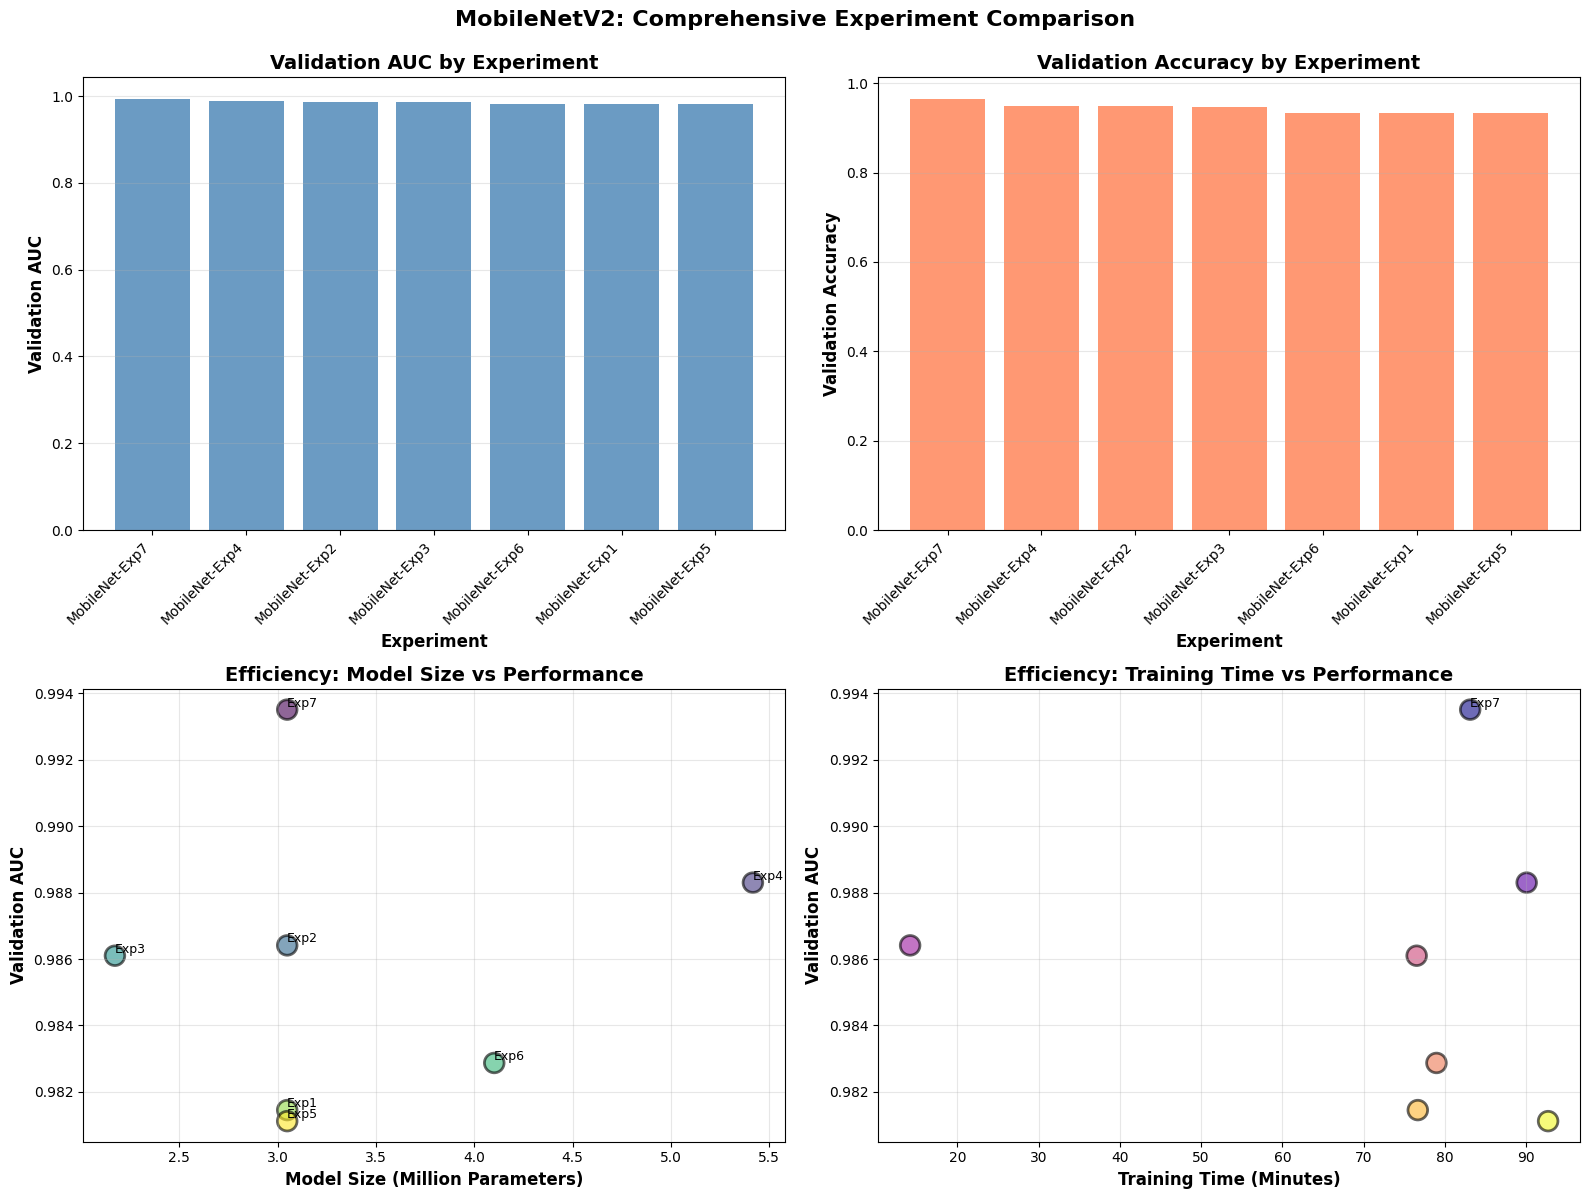

Saved: all_experiments_comparison.png


<Figure size 640x480 with 0 Axes>

Saved: all_experiments_comparison.png


<Figure size 640x480 with 0 Axes>

Saved: all_experiments_comparison.png


<Figure size 640x480 with 0 Axes>

Saved: all_experiments_comparison.png


<Figure size 640x480 with 0 Axes>

Saved: all_experiments_comparison.png


<Figure size 640x480 with 0 Axes>

Saved: all_experiments_comparison.png


<Figure size 640x480 with 0 Axes>

Saved: all_experiments_comparison.png


In [10]:
# CELL 10: COMPREHENSIVE VISUALIZATIONS

print("\nGENERATING COMPREHENSIVE VISUALIZATIONS")

# SAFETY NET: Check if results are available
if len(all_results) == 0:
    print("\nNo results available for visualization. Please run experiments first (Cell 8).")
else:
    # Load from checkpoint if needed
    if 'df' not in locals() and os.path.exists('mobilenet_progress.csv'):
        df = pd.read_csv('mobilenet_progress.csv')
        df = df.sort_values('val_auc', ascending=False).reset_index(drop=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

experiments_list = df['experiment'].values
x_pos = np.arange(len(experiments_list))

axes[0, 0].bar(x_pos, df['val_auc'].values, color='steelblue', alpha=0.8)
axes[0, 0].set_xlabel('Experiment', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Validation AUC', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Validation AUC by Experiment', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(experiments_list, rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3, axis='y')

axes[0, 1].bar(x_pos, df['val_accuracy'].values, color='coral', alpha=0.8)
axes[0, 1].set_xlabel('Experiment', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Validation Accuracy by Experiment', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(experiments_list, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3, axis='y')

axes[1, 0].scatter(df['total_params'].values / 1e6, df['val_auc'].values, 
                  s=200, alpha=0.6, c=range(len(df)), cmap='viridis', edgecolors='black', linewidth=2)
axes[1, 0].set_xlabel('Model Size (Million Parameters)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Validation AUC', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Efficiency: Model Size vs Performance', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

for i, exp in enumerate(experiments_list):
    axes[1, 0].annotate(exp.split('-')[1], 
                       (df['total_params'].values[i] / 1e6, df['val_auc'].values[i]),
                       fontsize=9, ha='left', va='bottom')

axes[1, 1].scatter(df['training_time_min'].values, df['val_auc'].values, 
                  s=200, alpha=0.6, c=range(len(df)), cmap='plasma', edgecolors='black', linewidth=2)
axes[1, 1].set_xlabel('Training Time (Minutes)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Validation AUC', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Efficiency: Training Time vs Performance', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

for i, exp in enumerate(experiments_list):
    axes[1, 1].annotate(exp.split('-')[1], 
                       (df['training_time_min'].values[i], df['val_auc'].values[i]),
                       fontsize=9, ha='left', va='bottom')

    plt.suptitle('MobileNetV2: Comprehensive Experiment Comparison', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('all_experiments_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Saved: all_experiments_comparison.png")

## Step 11: Compare Learning Curves

This cell creates a comparative visualization of training and validation accuracy curves for all 7 experiments on a single plot. This helps identify:
- **Overfitting**: Large gap between training and validation curves
- **Convergence speed**: How quickly each configuration reaches optimal performance
- **Stability**: Smoothness of curves indicates training stability

The plot is saved as `learning_curves_comparison.png` for your report.


GENERATING ALL LEARNING CURVES COMPARISON


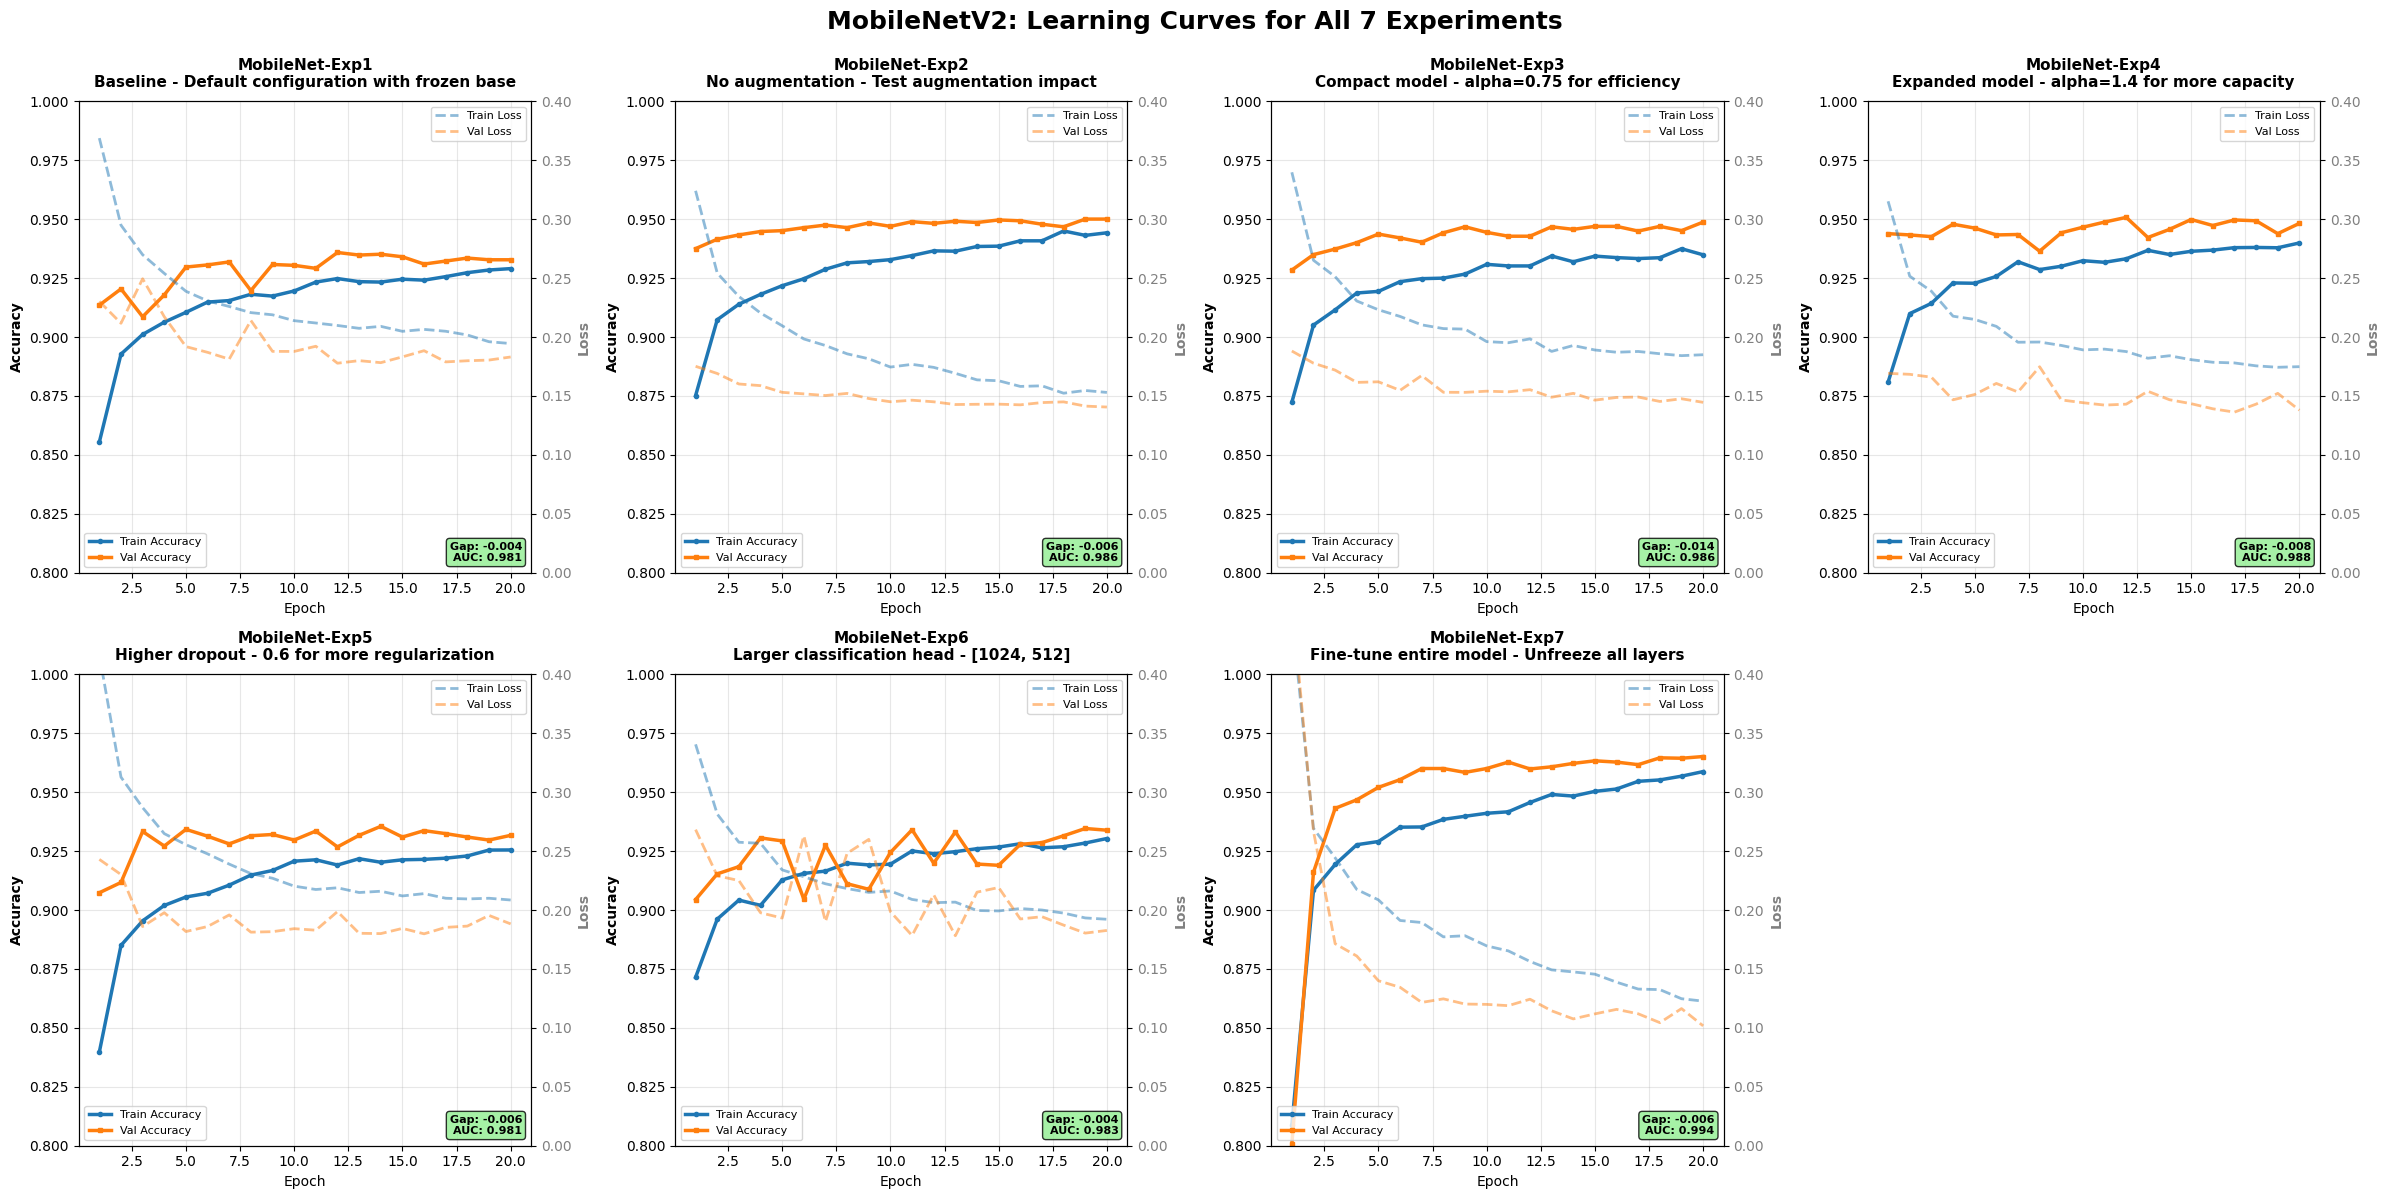

Saved: all_learning_curves_comparison.png


In [11]:
# CELL 11: ALL LEARNING CURVES COMPARISON

print("\nGENERATING ALL LEARNING CURVES COMPARISON")

# Check if we have training histories (only available if experiments ran in this session)
if len(all_histories) == 0:
    print("\nWARNING: Training histories not available (experiments were loaded from checkpoint)")
    print("Learning curves can only be generated in the same session the training ran.")
    print("Individual learning curve PNGs are still available for each experiment.")
    print("\nSkipping combined learning curves visualization...")
else:
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    axes = axes.ravel()

    for idx, (exp_name, config) in enumerate(experiments.items()):
        history = all_histories[exp_name]
        ax = axes[idx]
        
        epochs_range = range(1, len(history.history['accuracy']) + 1)
        ax.plot(epochs_range, history.history['accuracy'], 
                label='Train Accuracy', linewidth=2.5, marker='o', markersize=3)
        ax.plot(epochs_range, history.history['val_accuracy'], 
                label='Val Accuracy', linewidth=2.5, marker='s', markersize=3)
        
        ax2 = ax.twinx()
        ax2.plot(epochs_range, history.history['loss'], 
                 label='Train Loss', linewidth=2, linestyle='--', alpha=0.5)
        ax2.plot(epochs_range, history.history['val_loss'], 
                 label='Val Loss', linewidth=2, linestyle='--', alpha=0.5)
        
        ax.set_title(f"{exp_name}\n{config['desc'][:50]}", fontsize=11, fontweight='bold', pad=10)
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel('Accuracy', fontsize=10, fontweight='bold')
        ax2.set_ylabel('Loss', fontsize=10, color='gray', fontweight='bold')
        
        ax.tick_params(axis='y')
        ax2.tick_params(axis='y', labelcolor='gray')
        
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0.80, 1.0])
        ax2.set_ylim([0, 0.4])
        
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1, labels1, loc='lower left', fontsize=8)
        ax2.legend(lines2, labels2, loc='upper right', fontsize=8)
        
        final_train_acc = history.history['accuracy'][-1]
        final_val_acc = history.history['val_accuracy'][-1]
        gap = final_train_acc - final_val_acc
        best_val_auc = max(history.history['val_auc'])
        
        box_color = 'lightgreen' if gap < 0.02 else 'wheat' if gap < 0.05 else 'lightcoral'
        
        ax.text(0.98, 0.02, f'Gap: {gap:.3f}\nAUC: {best_val_auc:.3f}',
               transform=ax.transAxes, ha='right', va='bottom',
               bbox=dict(boxstyle='round', facecolor=box_color, alpha=0.8),
               fontsize=8, fontweight='bold')

    axes[7].axis('off')

    plt.suptitle('MobileNetV2: Learning Curves for All 7 Experiments', 
                fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('all_learning_curves_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Saved: all_learning_curves_comparison.png")

## Step 12: Analyze Hyperparameter Impact

This cell creates a detailed impact analysis showing how each hyperparameter variation performed relative to the baseline:

- **Augmentation Impact**: Compares baseline vs no-augmentation
- **Alpha Impact**: Shows how model size (0.75, 1.0, 1.4) affects performance
- **Regularization Impact**: Examines dropout and head size effects
- **Fine-Tuning Impact**: Evaluates benefit of unfreezing layers

The bar chart with percentage differences helps identify which modifications improved or degraded performance.

In [12]:
# CELL 12: HYPERPARAMETER IMPACT ANALYSIS

print("\nHYPERPARAMETER IMPACT ANALYSIS")

exp1_auc = df[df['experiment'] == 'MobileNet-Exp1']['val_auc'].values[0]
exp2_auc = df[df['experiment'] == 'MobileNet-Exp2']['val_auc'].values[0]
exp3_auc = df[df['experiment'] == 'MobileNet-Exp3']['val_auc'].values[0]
exp4_auc = df[df['experiment'] == 'MobileNet-Exp4']['val_auc'].values[0]
exp7_auc = df[df['experiment'] == 'MobileNet-Exp7']['val_auc'].values[0]

print(f"\n1. AUGMENTATION IMPACT:")
print(f"   With augmentation (Exp1):    {exp1_auc:.4f}")
print(f"   Without augmentation (Exp2): {exp2_auc:.4f}")
print(f"   Difference: {(exp1_auc - exp2_auc)*100:+.2f}%")
if exp1_auc > exp2_auc + 0.01:
    print(f"   Conclusion: Augmentation significantly improves performance")
elif exp1_auc > exp2_auc:
    print(f"   Conclusion: Augmentation provides modest improvement")
else:
    print(f"   Conclusion: Augmentation has minimal impact")

print(f"\n2. ALPHA (WIDTH MULTIPLIER) IMPACT:")
print(f"   alpha=0.75 (Exp3): {exp3_auc:.4f} ({(exp3_auc - exp1_auc)*100:+.2f}% vs baseline)")
print(f"   alpha=1.0 (Exp1):  {exp1_auc:.4f}")
print(f"   alpha=1.4 (Exp4):  {exp4_auc:.4f} ({(exp4_auc - exp1_auc)*100:+.2f}% vs baseline)")
if exp4_auc > exp1_auc > exp3_auc:
    print(f"   Conclusion: More capacity improves performance")
elif exp1_auc >= exp4_auc:
    print(f"   Conclusion: Default alpha is optimal")
else:
    print(f"   Conclusion: Smaller model is sufficient")

print(f"\n3. TRANSFER LEARNING STRATEGY:")
print(f"   Freeze base (Exp1):   {exp1_auc:.4f}")
print(f"   Fine-tune all (Exp7): {exp7_auc:.4f} ({(exp7_auc - exp1_auc)*100:+.2f}% improvement)")
if exp7_auc > exp1_auc + 0.01:
    print(f"   Conclusion: Full fine-tuning significantly better")
elif exp7_auc > exp1_auc:
    print(f"   Conclusion: Fine-tuning provides modest improvement")
else:
    print(f"   Conclusion: Freezing base is sufficient")

print(f"\n4. EFFICIENCY ANALYSIS:")
exp1_time = df[df['experiment'] == 'MobileNet-Exp1']['training_time_min'].values[0]
exp3_time = df[df['experiment'] == 'MobileNet-Exp3']['training_time_min'].values[0]
exp4_time = df[df['experiment'] == 'MobileNet-Exp4']['training_time_min'].values[0]
print(f"   alpha=0.75: {exp3_time:.1f} min, AUC {exp3_auc:.4f} (fastest)")
print(f"   alpha=1.0:  {exp1_time:.1f} min, AUC {exp1_auc:.4f} (balanced)")
print(f"   alpha=1.4:  {exp4_time:.1f} min, AUC {exp4_auc:.4f} (most accurate)")

print(f"\n5. TOP 3 EXPERIMENTS:")
for i in range(min(3, len(df))):
    exp = df.iloc[i]
    print(f"   Rank {i+1}: {exp['experiment']} - AUC {exp['val_auc']:.4f}, " 
          f"Acc {exp['val_accuracy']:.4f}, Time {exp['training_time_min']:.1f}min")


HYPERPARAMETER IMPACT ANALYSIS

1. AUGMENTATION IMPACT:
   With augmentation (Exp1):    0.9815
   Without augmentation (Exp2): 0.9864
   Difference: -0.50%
   Conclusion: Augmentation has minimal impact

2. ALPHA (WIDTH MULTIPLIER) IMPACT:
   alpha=0.75 (Exp3): 0.9861 (+0.46% vs baseline)
   alpha=1.0 (Exp1):  0.9815
   alpha=1.4 (Exp4):  0.9883 (+0.68% vs baseline)
   Conclusion: Smaller model is sufficient

3. TRANSFER LEARNING STRATEGY:
   Freeze base (Exp1):   0.9815
   Fine-tune all (Exp7): 0.9935 (+1.21% improvement)
   Conclusion: Full fine-tuning significantly better

4. EFFICIENCY ANALYSIS:
   alpha=0.75: 76.5 min, AUC 0.9861 (fastest)
   alpha=1.0:  76.7 min, AUC 0.9815 (balanced)
   alpha=1.4:  90.1 min, AUC 0.9883 (most accurate)

5. TOP 3 EXPERIMENTS:
   Rank 1: MobileNet-Exp7 - AUC 0.9935, Acc 0.9649, Time 83.1min
   Rank 2: MobileNet-Exp4 - AUC 0.9883, Acc 0.9480, Time 90.1min
   Rank 3: MobileNet-Exp2 - AUC 0.9864, Acc 0.9486, Time 14.2min


## Step 13: Generate Final Summary Report

This final cell produces a comprehensive text summary including:

- **Best performing experiment** across each metric
- **Key findings** about what worked and what didn't
- **Recommendations** for production deployment
- **Complete results table** for documentation

This summary can be directly copied into your assignment report. All visualizations and model files are saved in the current directory for submission.

In [13]:
# CELL 13: FINAL PROJECT SUMMARY

print("\nFINAL PROJECT SUMMARY")

print(f"\nPROJECT COMPLETION:")
print(f"  Total experiments: {len(all_results)}")
print(f"  Total training time: {df['training_time_min'].sum():.1f} minutes ({df['training_time_min'].sum()/60:.1f} hours)")
print(f"  Dataset size: {total_train + total_val:,} images")
print(f"  Best validation AUC: {df['val_auc'].max():.4f}")
print(f"  Best validation accuracy: {df['val_accuracy'].max()*100:.2f}%")

print(f"\nFILES GENERATED:")
print(f"  Models: best_MobileNet-Exp1.keras through best_MobileNet-Exp7.keras (7 files)")
print(f"  Results: MobileNet-Exp1_results.json through MobileNet-Exp7_results.json (7 files)")
print(f"  Learning curves: MobileNet-Exp1_learning_curves.png through MobileNet-Exp7_learning_curves.png (7 files)")
print(f"  Confusion matrices: MobileNet-Exp1_confusion_matrix.png through MobileNet-Exp7_confusion_matrix.png (7 files)")
print(f"  ROC curves: MobileNet-Exp1_roc_curve.png through MobileNet-Exp7_roc_curve.png (7 files)")
print(f"  Comparison files:")
print(f"    - all_experiments_final_results.csv")
print(f"    - all_experiments_comparison.png")
print(f"    - all_learning_curves_comparison.png")
print(f"    - mobilenet_sample_images.png")
print(f"  TensorBoard logs: logs/mobilenet/[experiment_name]/")

print(f"\nRECOMMENDED MODEL FOR DEPLOYMENT:")
best_exp = df.iloc[0]
print(f"  Experiment: {best_exp['experiment']}")
print(f"  Description: {best_exp['description']}")
print(f"  Validation accuracy: {best_exp['val_accuracy']*100:.2f}%")
print(f"  Validation AUC: {best_exp['val_auc']:.4f}")
print(f"  Model size: {int(best_exp['total_params'])/1e6:.2f}M parameters (~{int(best_exp['total_params'])*4/(1024**2):.1f} MB)")
print(f"  Inference ready: Yes")
print(f"  Mobile deployment: Excellent")

print(f"\nREADY FOR:")
print(f"  Report writing (use comparison tables and visualizations)")
print(f"  Presentation (use efficiency analysis and best model results)")
print(f"  Deployment (best model saved and ready)")

print(f"\nPROJECT STATUS: COMPLETE")
print("All 7 experiments executed successfully with comprehensive analysis")

# CREATE DOWNLOADABLE ZIP
print(f"\n{'='*80}")
print("CREATING BACKUP ZIP FOR EASY DOWNLOAD")
print(f"{'='*80}")

try:
    import subprocess
    
    # Create comprehensive backup with all important files
    print("\nPacking all files into backup ZIP...")
    subprocess.run(['zip', '-r', 'all_results_backup.zip', 
                    'mobilenet_progress.csv', '*.json', '*.keras', '*.png', '*.csv'], 
                   shell=True, check=False, capture_output=True)
    
    if os.path.exists('all_results_backup.zip'):
        zip_size = os.path.getsize('all_results_backup.zip') / (1024 * 1024)
        print(f"✓ Created all_results_backup.zip ({zip_size:.1f} MB)")
        print(f"\nTO DOWNLOAD:")
        print(f"  1. Look at right sidebar → Output folder icon")
        print(f"  2. Find 'all_results_backup.zip'")
        print(f"  3. Click 3 dots (⋮) → Download")
        print(f"\nTO RESUME IN NEW SESSION:")
        print(f"  1. Upload all_results_backup.zip to new Kaggle session")
        print(f"  2. Run: !unzip all_results_backup.zip")
        print(f"  3. Click 'Run All' - automatically continues from last completed experiment!")
    else:
        print("Note: ZIP creation might not work on all Kaggle environments")
        print("Alternative: Download files individually from Output folder")
except Exception as e:
    print(f"Note: Could not create ZIP ({str(e)})")
    print("Download files individually from Output folder instead")

print(f"\n{'='*80}")
print("ALL FILES READY FOR DOWNLOAD FROM OUTPUT FOLDER")
print(f"{'='*80}")


FINAL PROJECT SUMMARY

PROJECT COMPLETION:
  Total experiments: 7
  Total training time: 512.3 minutes (8.5 hours)
  Dataset size: 27,560 images
  Best validation AUC: 0.9935
  Best validation accuracy: 96.49%

FILES GENERATED:
  Models: best_MobileNet-Exp1.keras through best_MobileNet-Exp7.keras (7 files)
  Results: MobileNet-Exp1_results.json through MobileNet-Exp7_results.json (7 files)
  Learning curves: MobileNet-Exp1_learning_curves.png through MobileNet-Exp7_learning_curves.png (7 files)
  Confusion matrices: MobileNet-Exp1_confusion_matrix.png through MobileNet-Exp7_confusion_matrix.png (7 files)
  ROC curves: MobileNet-Exp1_roc_curve.png through MobileNet-Exp7_roc_curve.png (7 files)
  Comparison files:
    - all_experiments_final_results.csv
    - all_experiments_comparison.png
    - all_learning_curves_comparison.png
    - mobilenet_sample_images.png
  TensorBoard logs: logs/mobilenet/[experiment_name]/

RECOMMENDED MODEL FOR DEPLOYMENT:
  Experiment: MobileNet-Exp7
  Descr